In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import time
from tqdm.notebook import tqdm

from proteolizarddata.data import PyTimsDataHandle, TimsFrame, MzSpectrum
from proteolizardalgo.hashing import TimsHasher, IsotopeReferenceSearch, ReferencePattern
from proteolizardalgo.utility import create_reference_dict, get_refspec_list, get_ref_pattern_as_spectra

import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KDTree

In [2]:
PEAKNET = tf.keras.models.load_model('../PEAKNET/', custom_objects={'loss_charge': '', 'loss_label': ''})

In [3]:
dh = PyTimsDataHandle('../data/M210115_001_Slot1-1_1_850.d/')

In [96]:
# generate hasher
hasher = TimsHasher(trials=128, len_trial=32, seed=42, num_dalton=10, resolution=1)

In [97]:
for f in tqdm(dh.precursor_frames[1800:]):
    frame = dh.get_frame(f)
    frame = hasher.filter_frame_auto_correlation(frame, min_intensity=25, min_peaks=6)
    break

  0%|          | 0/7005 [00:00<?, ?it/s]

  0%|          | 0/7005 [00:00<?, ?it/s]

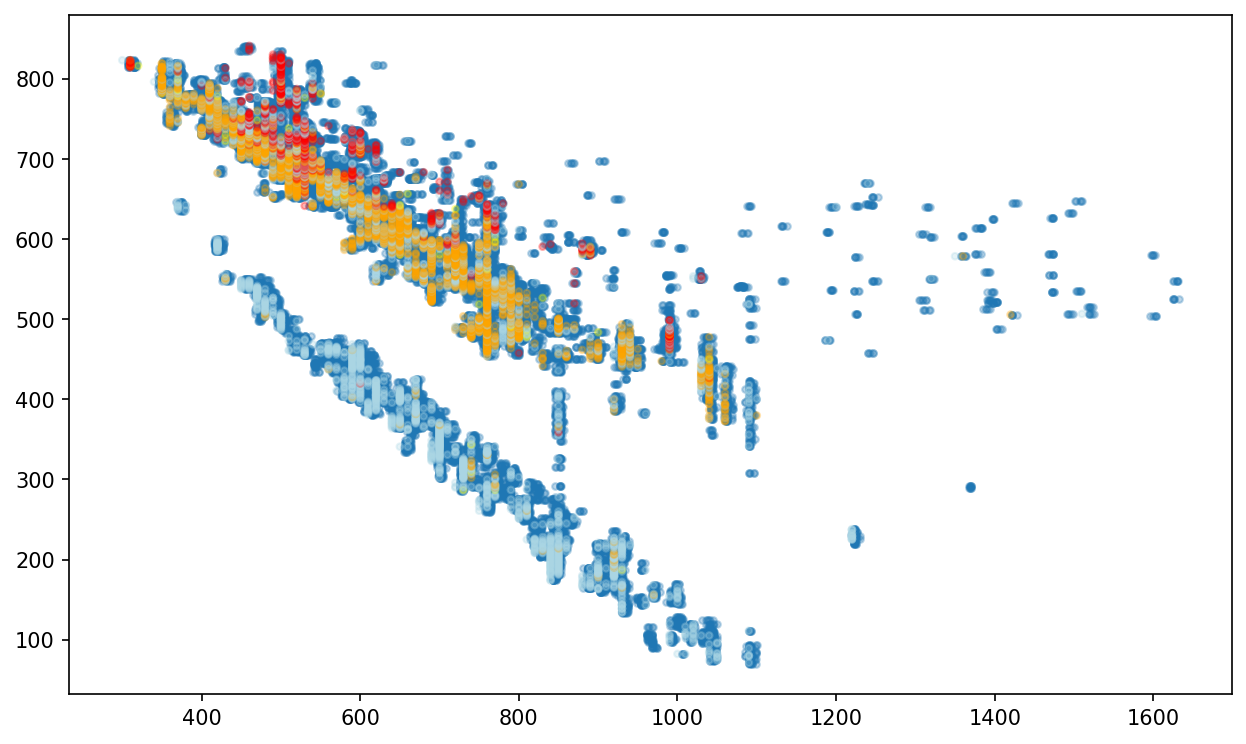

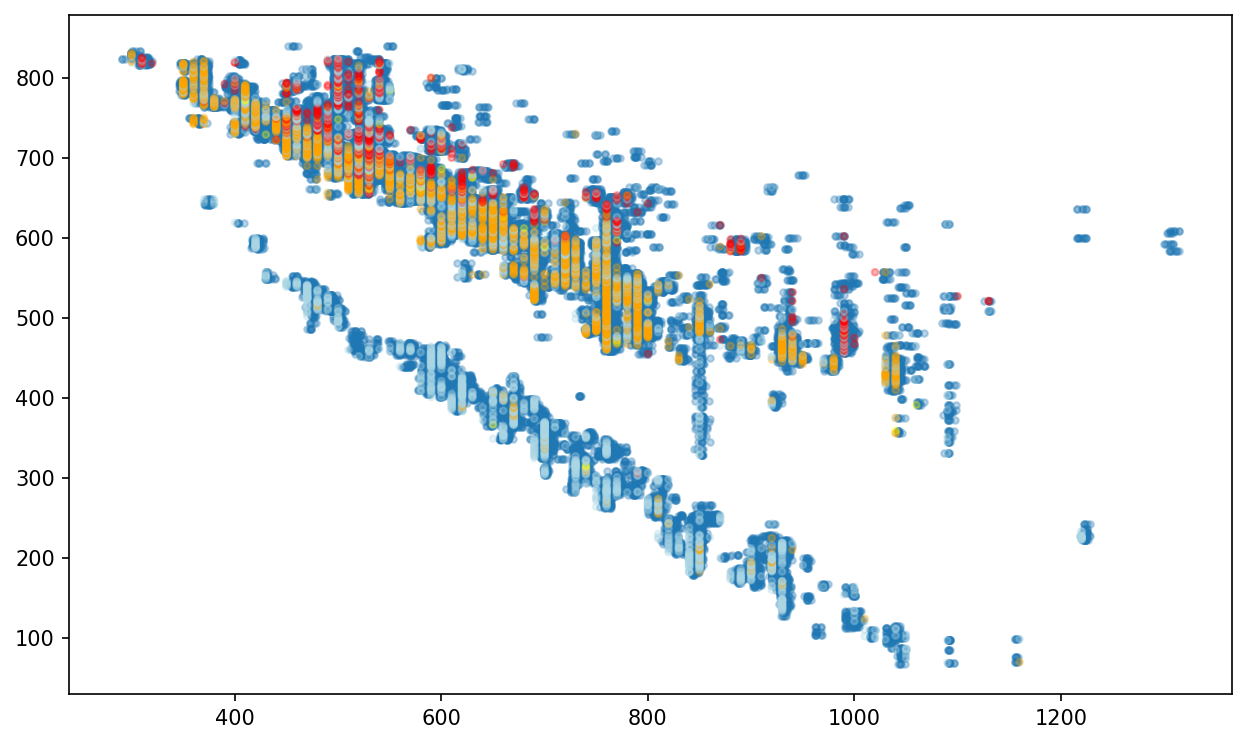

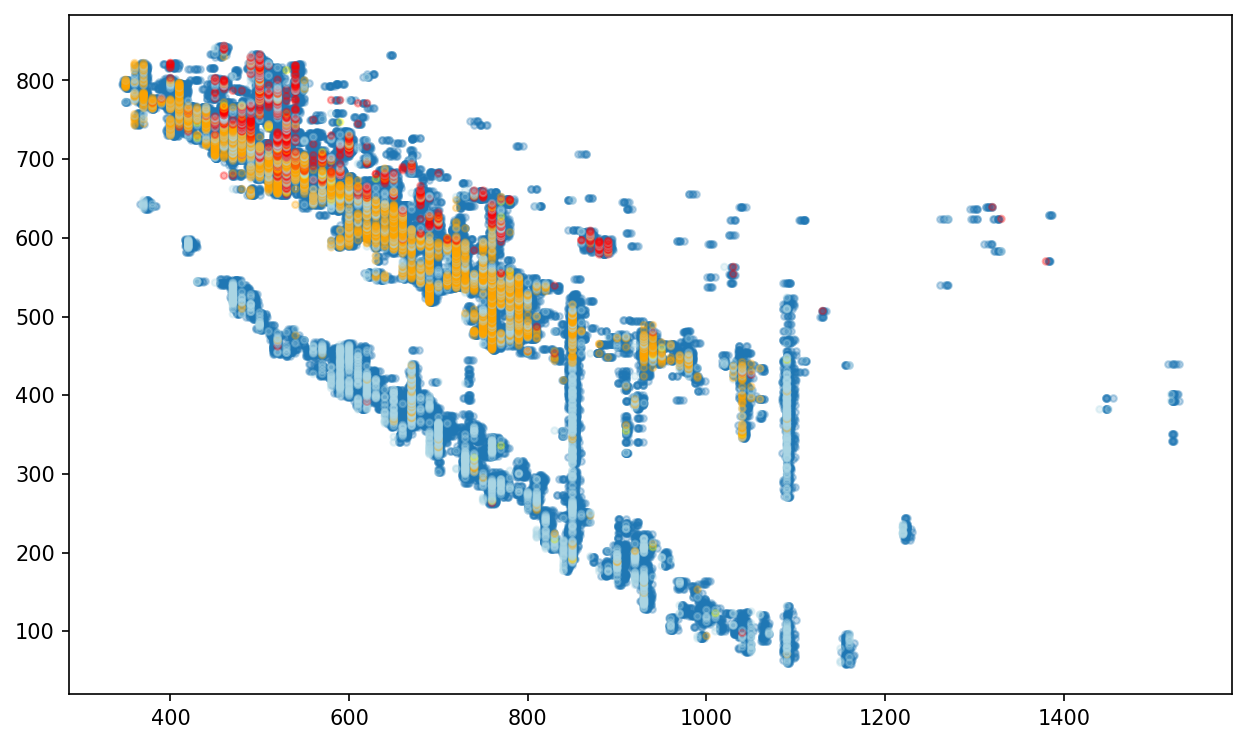

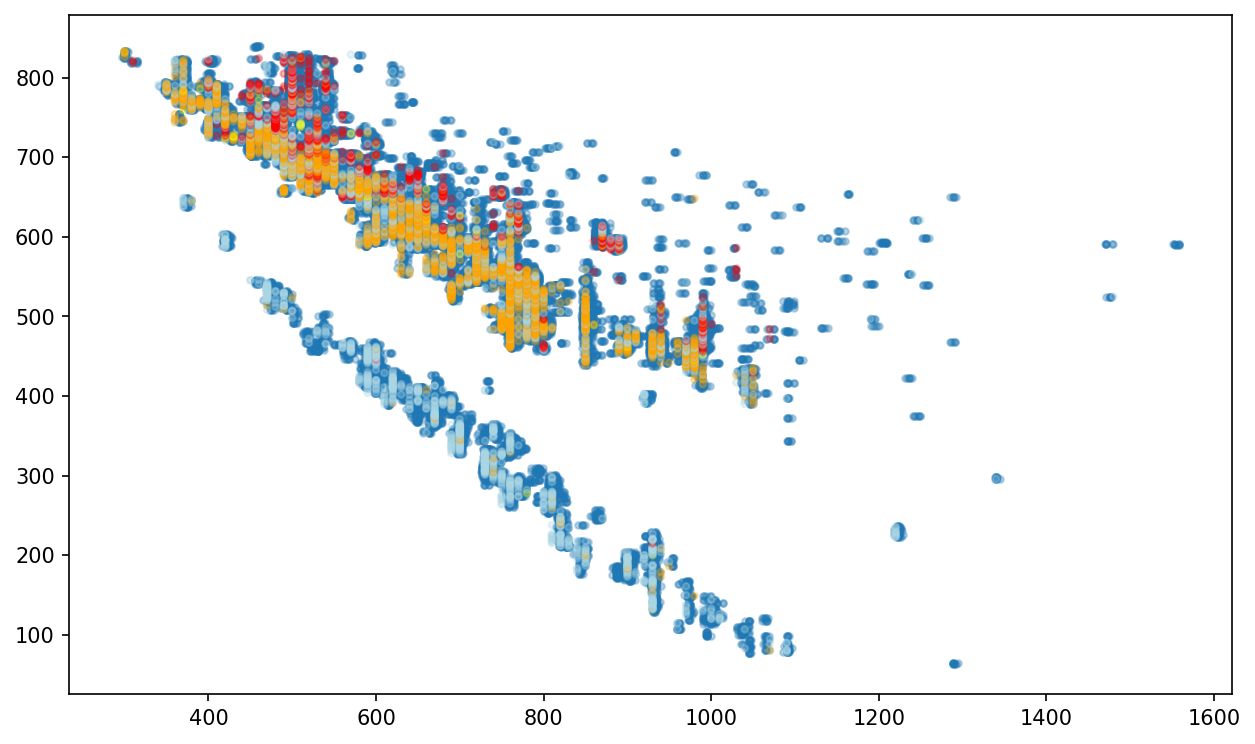

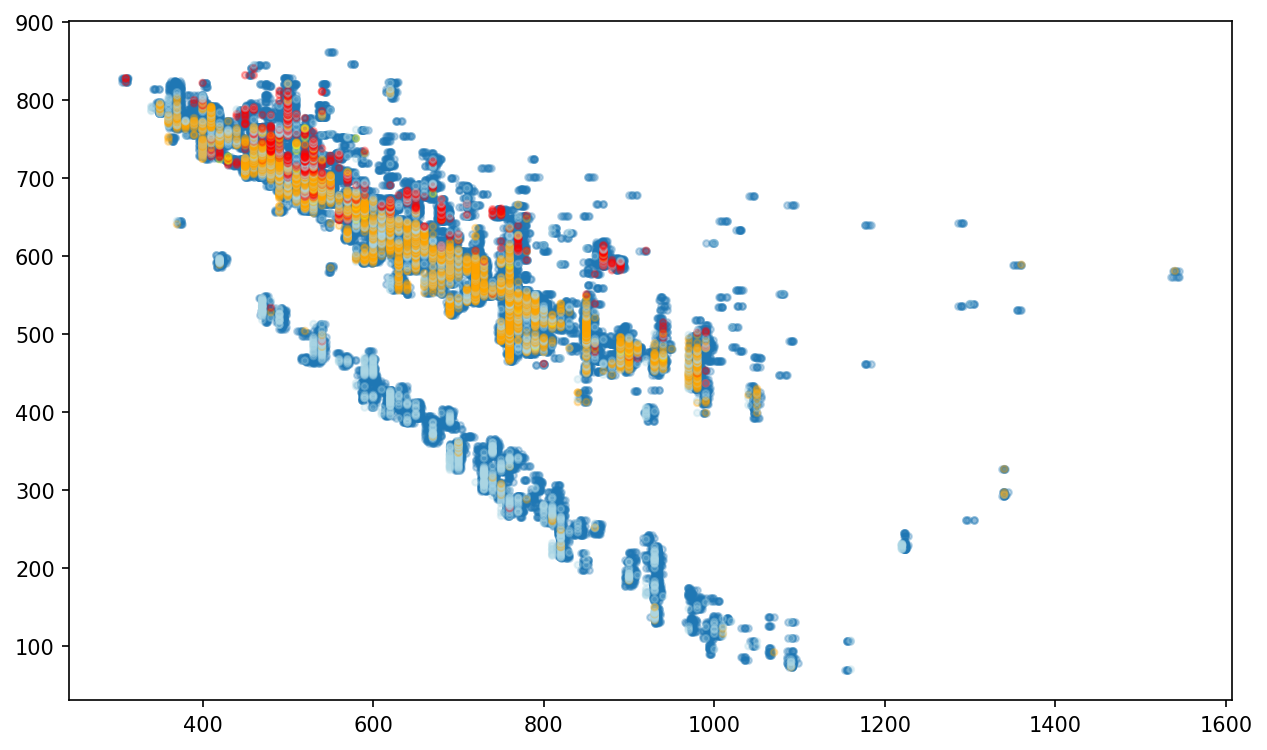

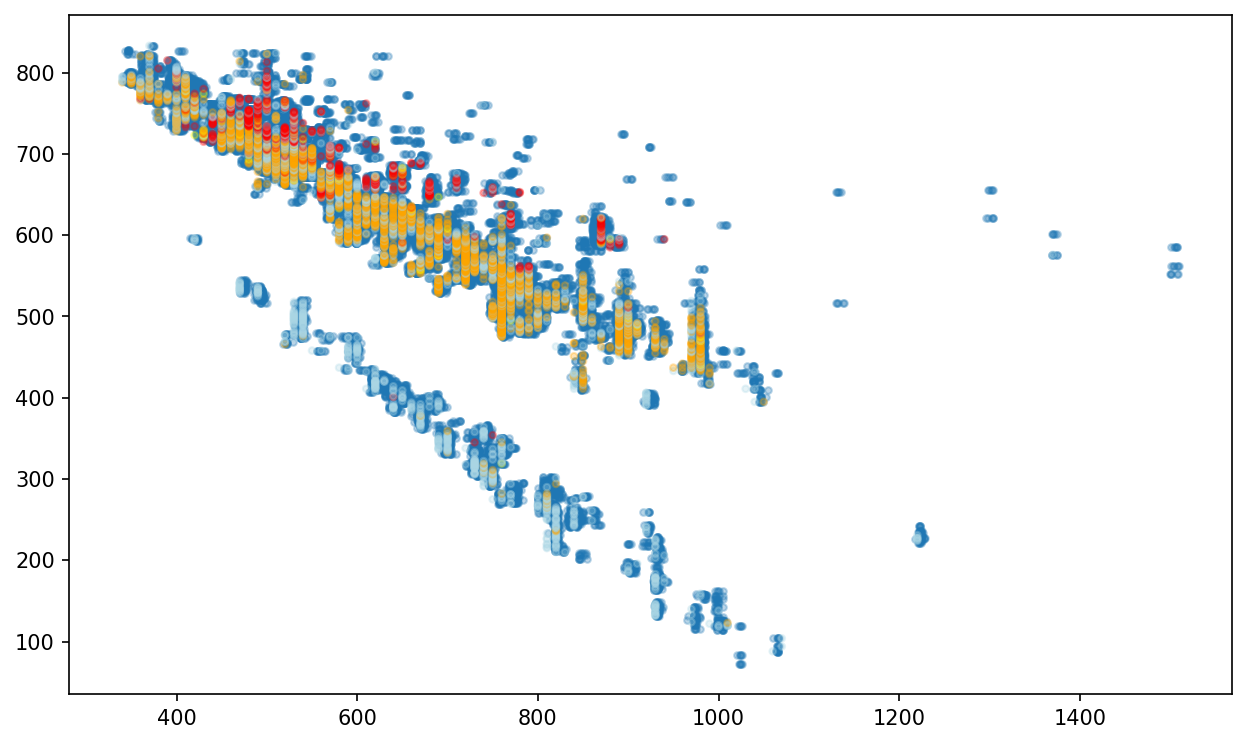

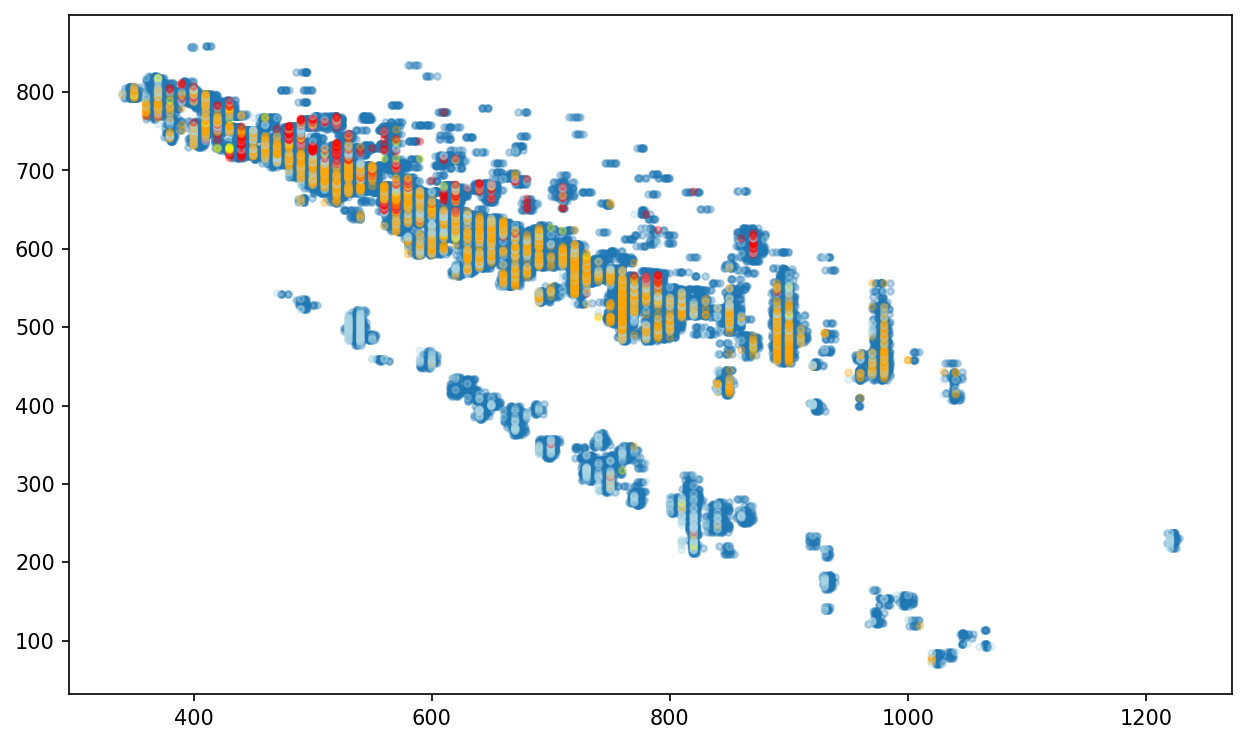

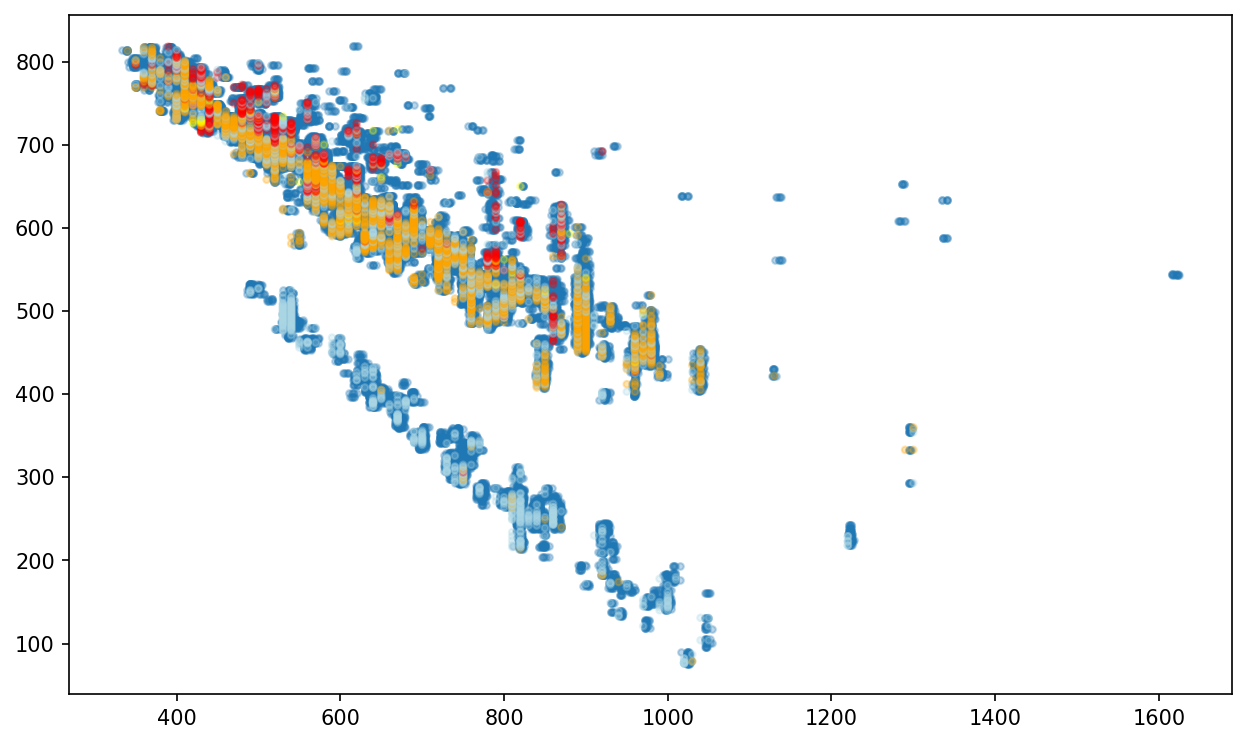

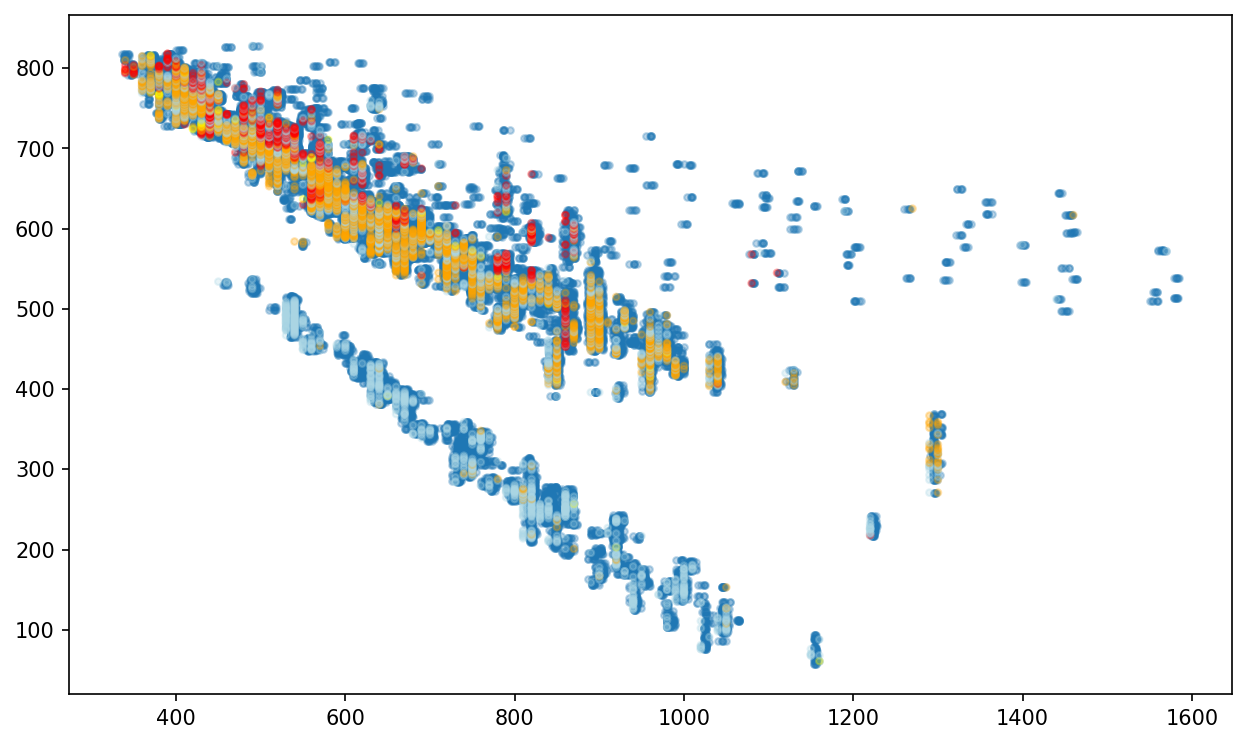

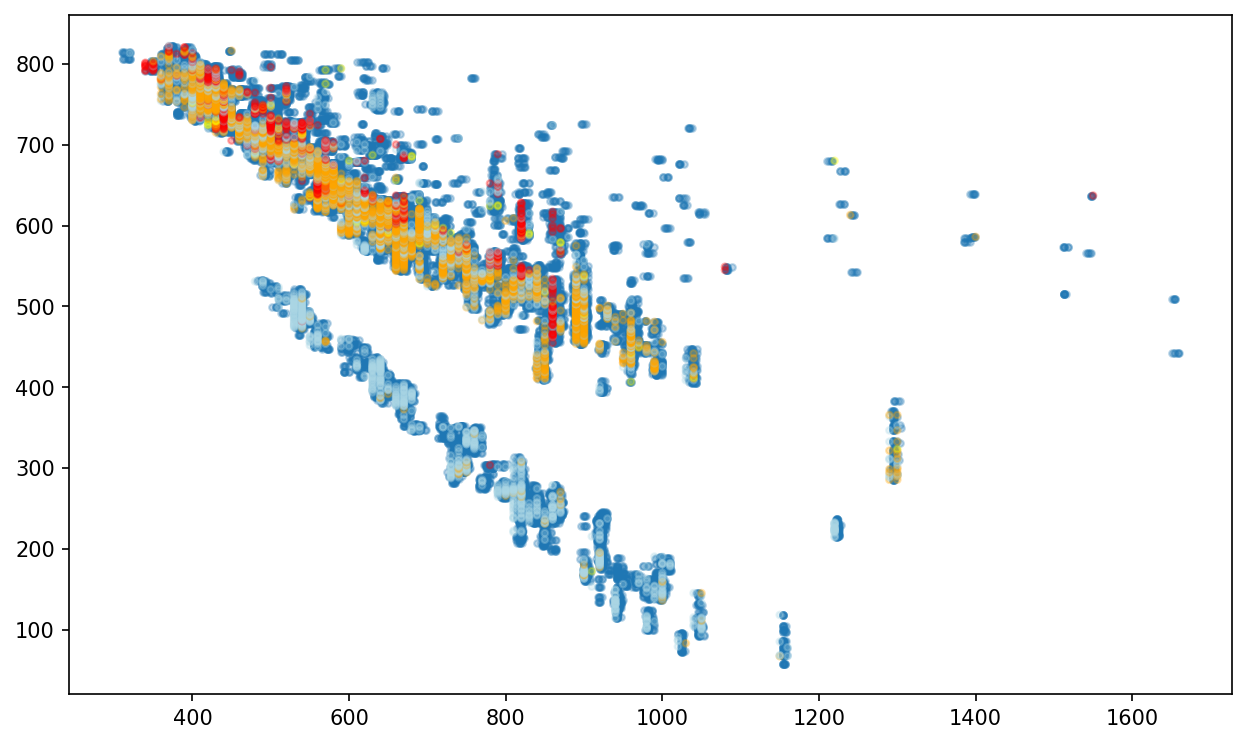

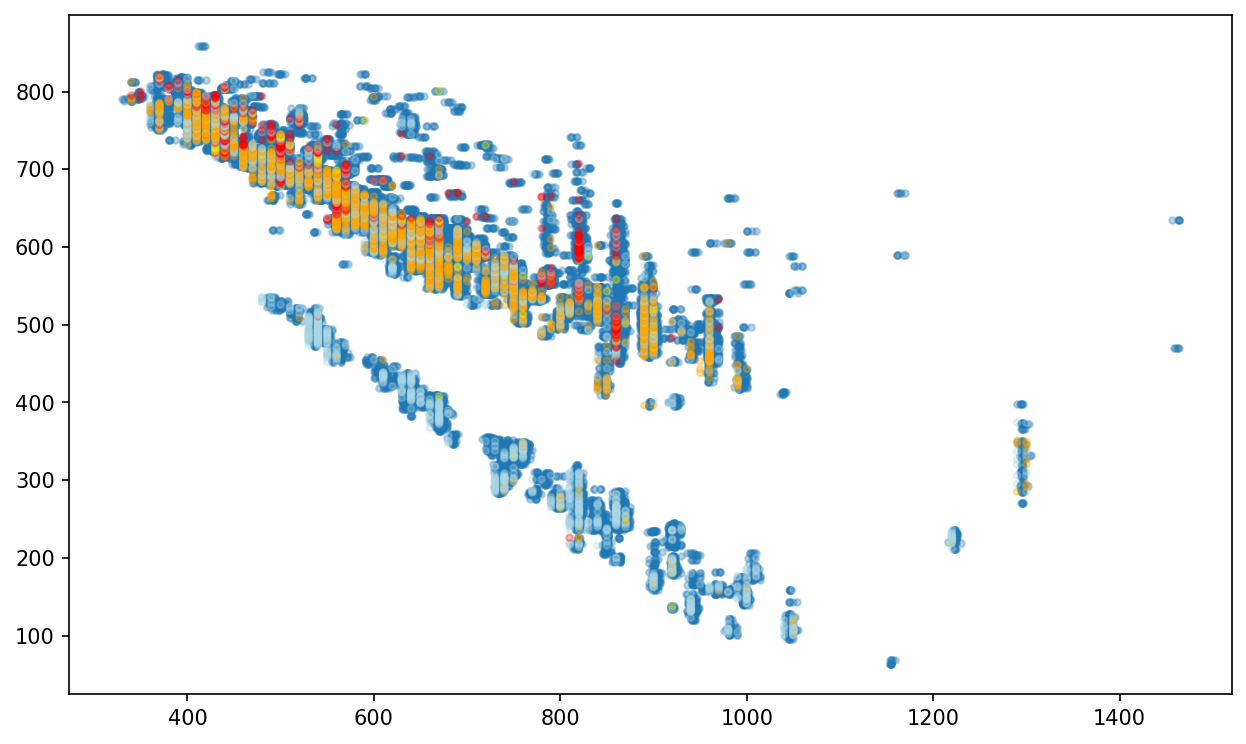

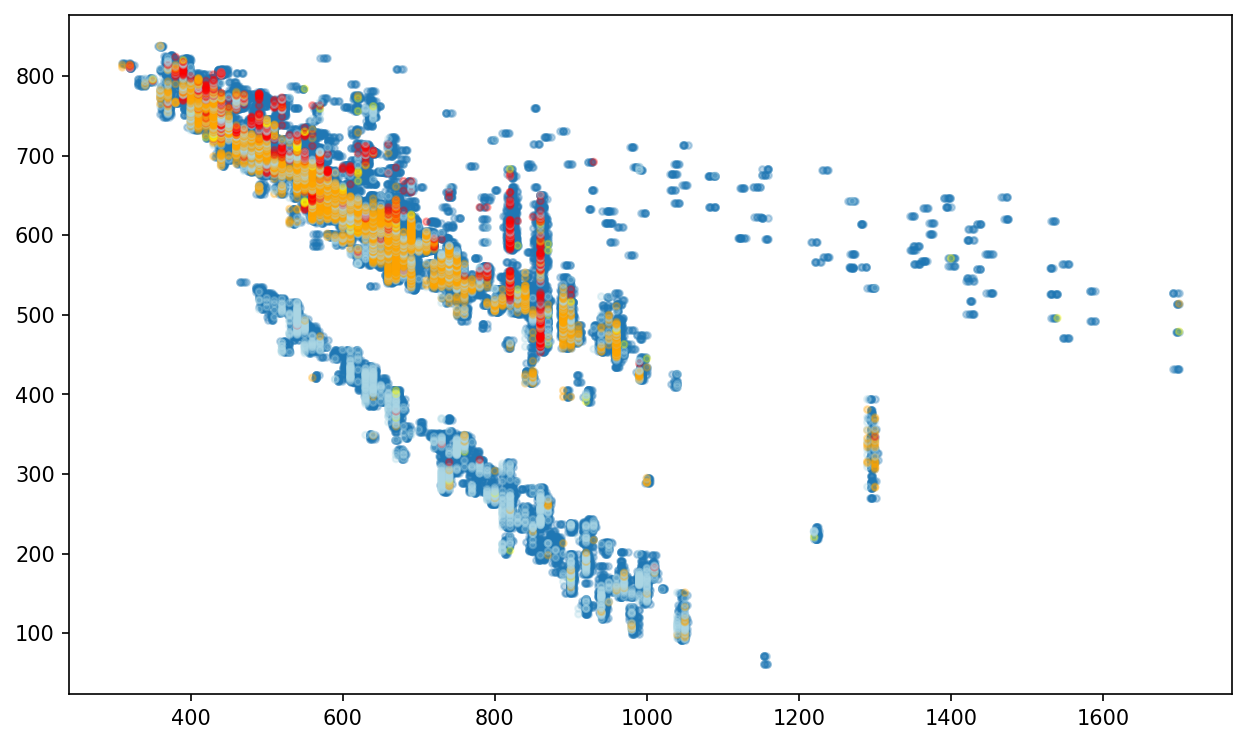

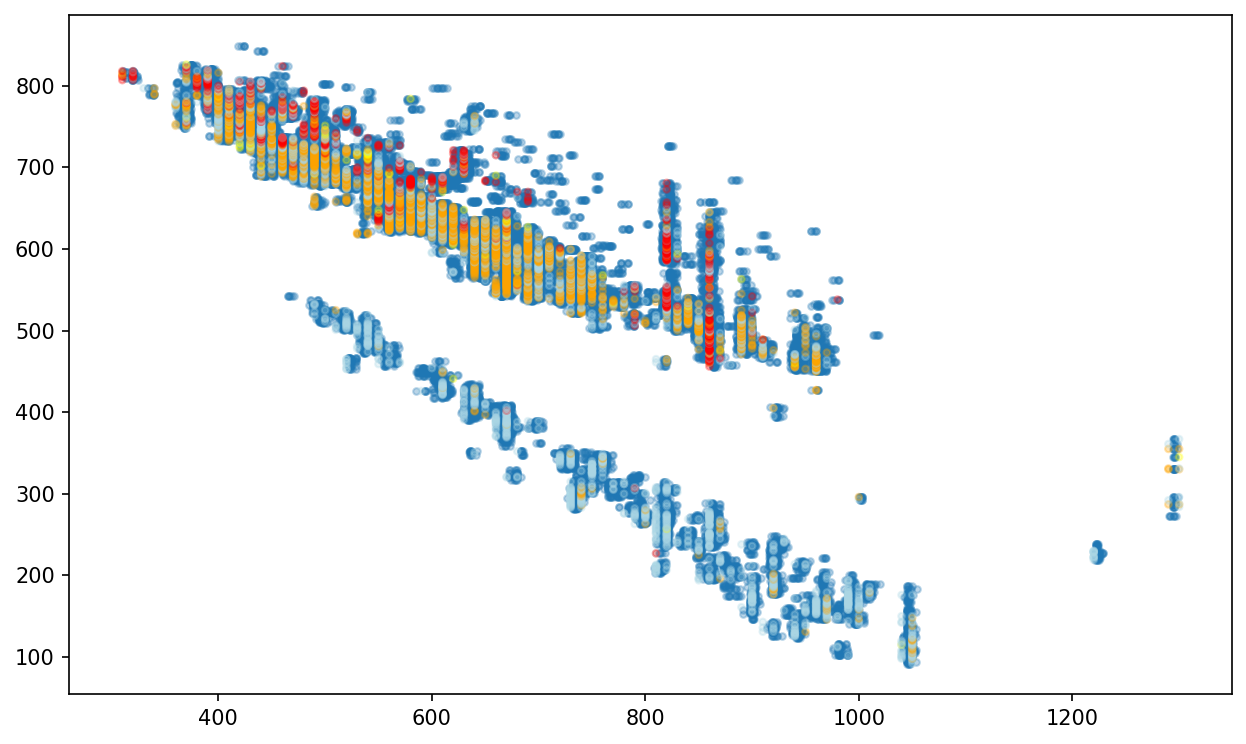

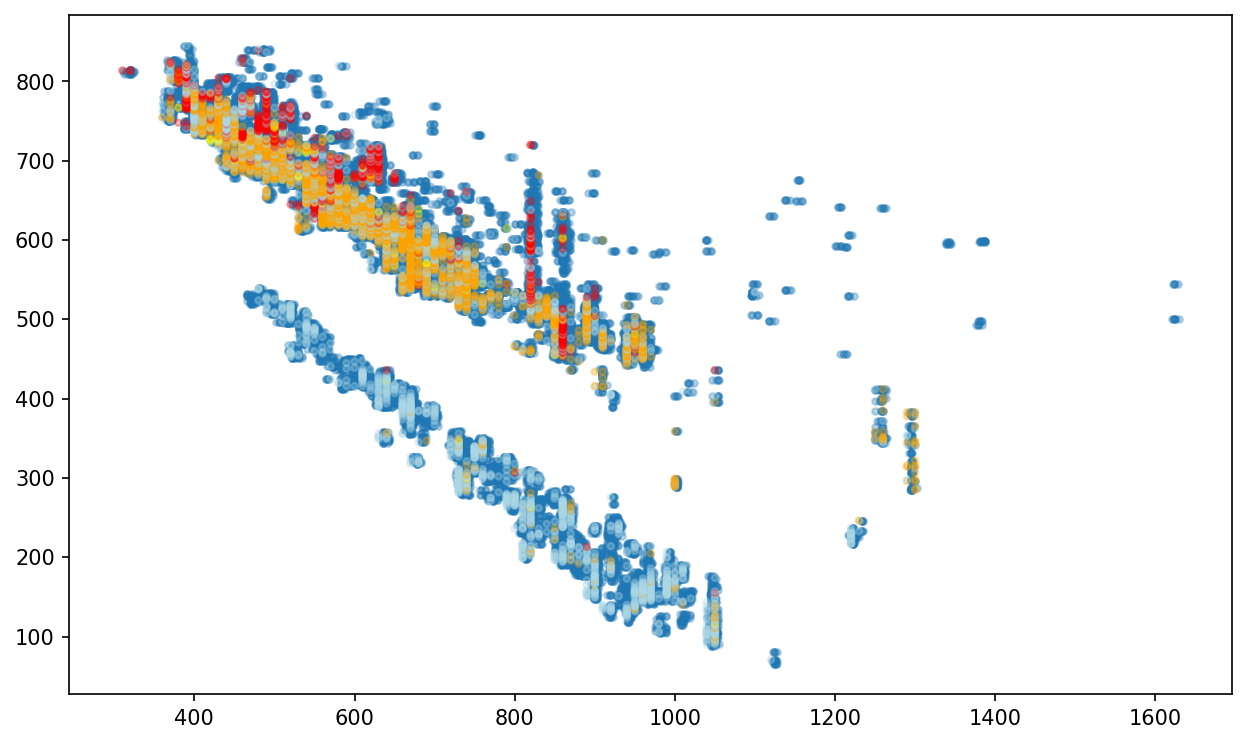

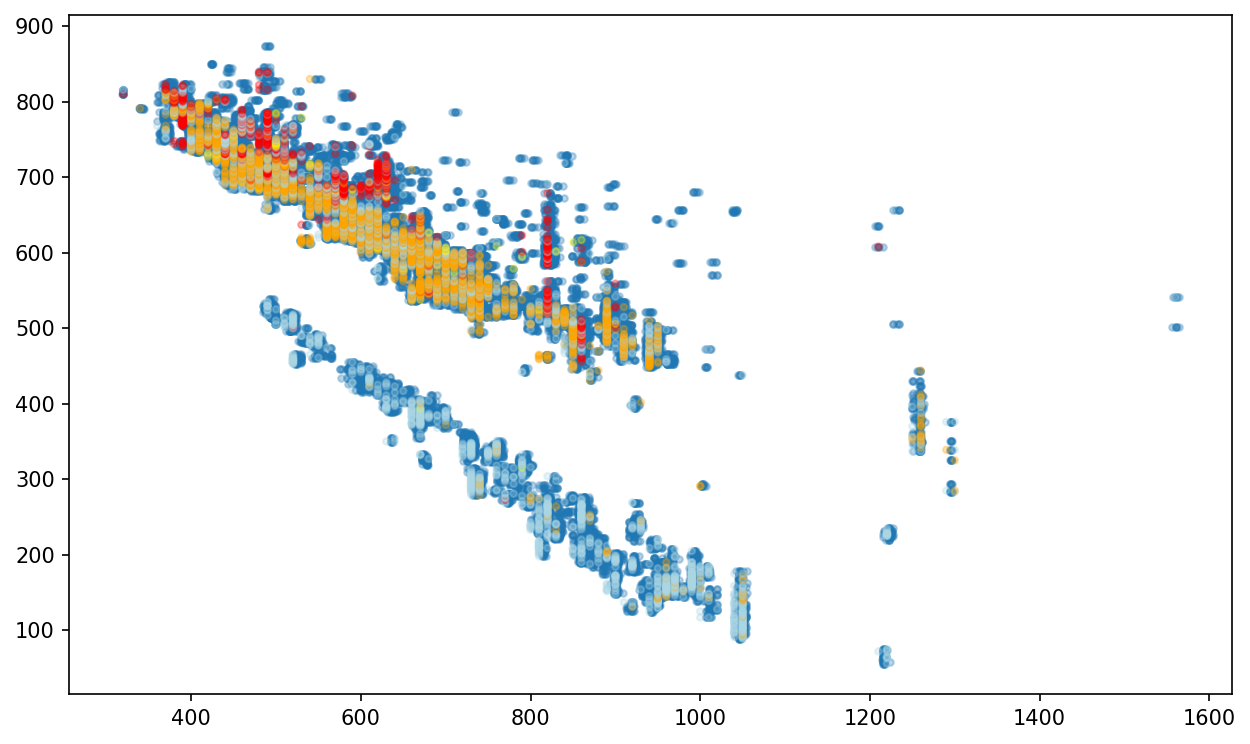

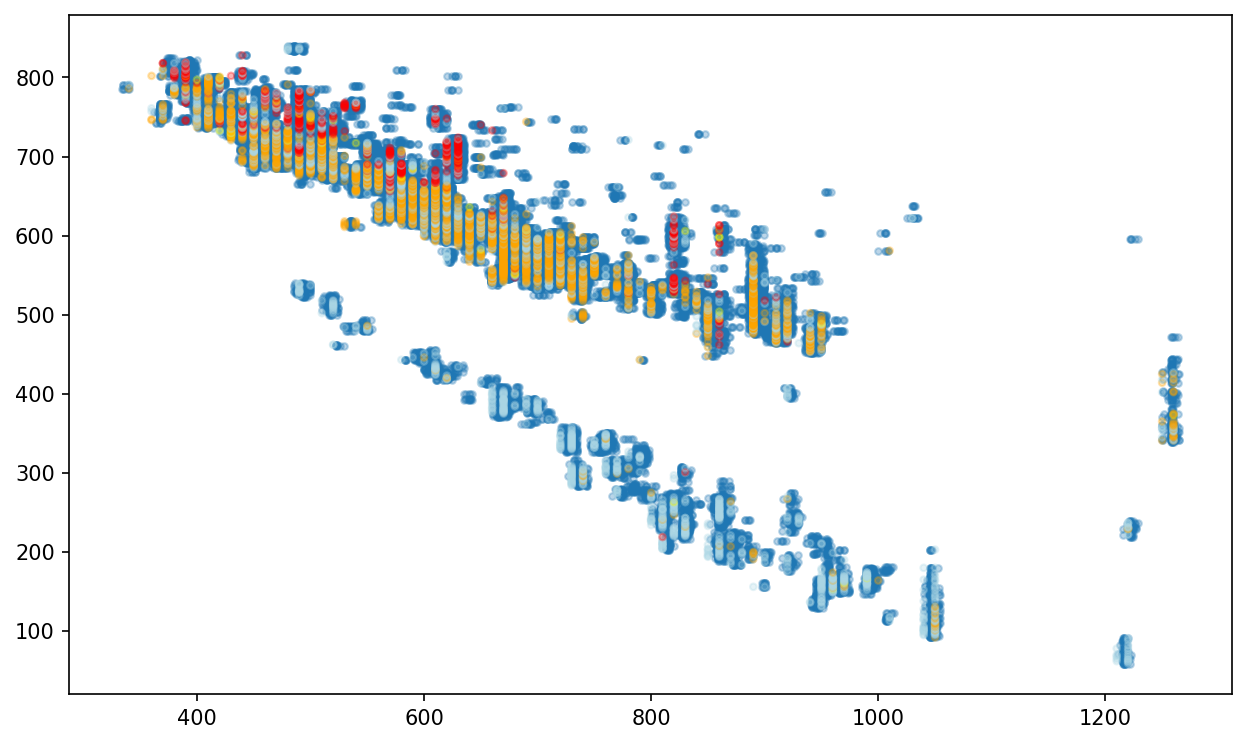

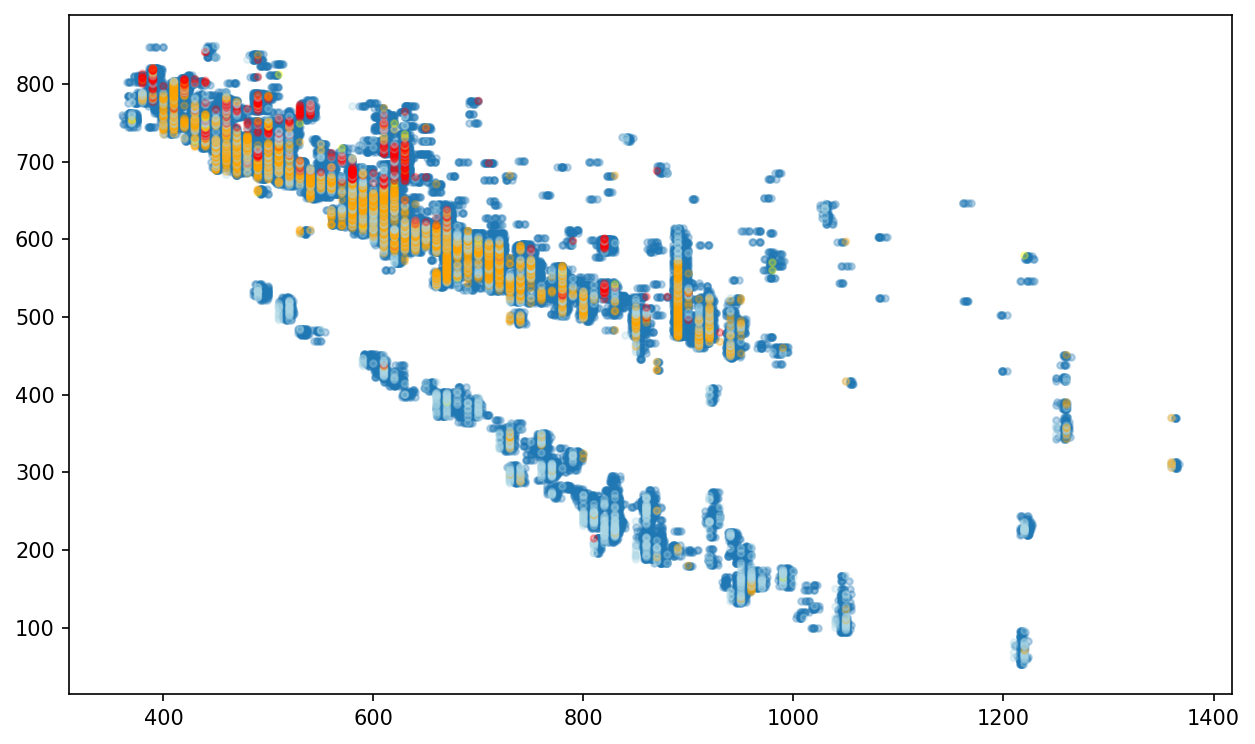

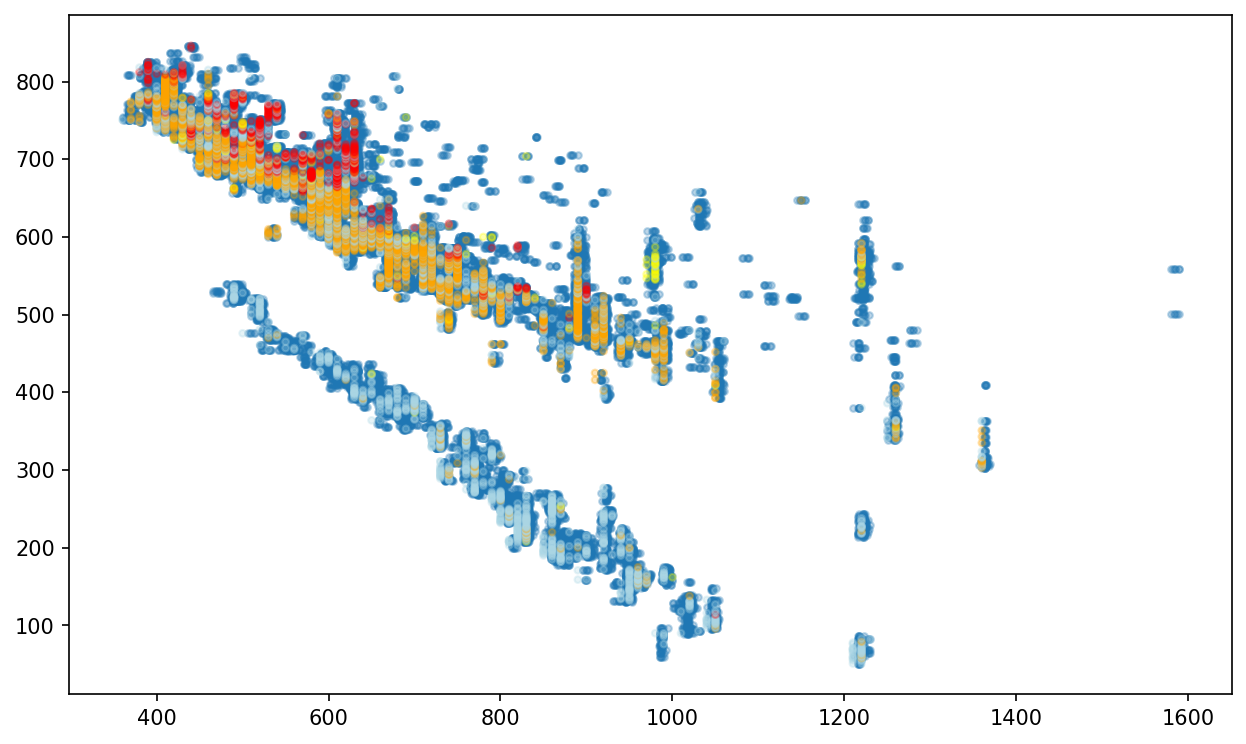

KeyboardInterrupt: 

In [104]:
for f in tqdm(dh.precursor_frames[1800:]):
    
    frame = dh.get_frame(f)
    frame = hasher.filter_frame_auto_correlation(frame, min_intensity=25, min_peaks=5)
    
    s, b, W = frame.get_dense_windows(window_length=10, resolution=2)
    
    W = W / tf.reshape(tf.reduce_sum(W, axis=1), (-1, 1))

    ds = tf.data.Dataset.from_tensor_slices(tf.expand_dims(W[:, :1000], 
                                                           axis=2)).batch(int(np.power(2, 11))).prefetch(20)

    c, l = PEAKNET.predict(ds)
    c = np.argmax(c, axis=1) + 1
    l = np.squeeze(np.round(l).astype(np.bool8))

    s_f = s[l]
    b_f = b[l]
    c_f = c[l]
    
    color_dict = {1:'lightblue', 2:'orange', 3:'red', 4:'yellow', 5:'yellow'}

    plt.figure(figsize=(10, 6), dpi=150)
    plt.scatter(frame.data().mz, frame.data().scan, s=10, alpha=.3)
    plt.scatter(np.abs(b_f) * 10, s_f, s=10, alpha=.3, color=[color_dict[x] for x in c_f])
    plt.show()

In [84]:
for f in tqdm(dh.precursor_frames[1800:]):
    
    frame = dh.get_frame(f)
    # frame = hasher.filter_frame_auto_correlation(frame, min_intensity=25, min_peaks=5)
    
    s, b, W = frame.get_dense_windows(window_length=10, resolution=2)
    
    W = W / tf.reshape(tf.reduce_sum(W, axis=1), (-1, 1))

    ds = tf.data.Dataset.from_tensor_slices(tf.expand_dims(W[:, :1000], axis=2)).batch(1024).prefetch(2)

    c, l = PEAKNET.predict(ds)
    c = np.argmax(c, axis=1) + 1
    l = np.squeeze(np.round(l).astype(np.bool8))

    s_f = s[l]
    b_f = b[l]
    c_f = c[l]
    
    color_dict = {1:'lightblue', 2:'orange', 3:'red', 4:'yellow', 5:'yellow'}

    """
    plt.figure(figsize=(10, 6), dpi=150)
    plt.scatter(np.abs(b_f), s_f, s=10, alpha=.3, color=[color_dict[x] for x in c_f])
    plt.show()
    """

  0%|          | 0/7005 [00:00<?, ?it/s]

KeyboardInterrupt: 